In [224]:
import numpy as np 
import pandas as pd 

import os
image_paths=[]
for dirname, _, filenames in os.walk('C:\\Users\\Mudra\\Downloads\\assignment 1'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))

In [225]:
from PIL import Image
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)

In [4]:
import sys
!{sys.executable} -m pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: C:\Users\Mudra\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [226]:
# counts number of images in each class
def classes_counter(labels, class_name):
    counter = 0
    for l in labels:
        if l == class_name:
            counter += 1
    return counter

counter_mtb = classes_counter(labels, "Motorbikes")
counter_arp = classes_counter(labels, "airplanes")
counter_sch = classes_counter(labels, "schooner")

def display_counts():
    counter_mtb = classes_counter(labels, "Motorbikes")
    counter_arp = classes_counter(labels, "airplanes")
    counter_sch = classes_counter(labels, "schooner")
    print(counter_mtb, counter_arp, counter_sch)

In [227]:
def make_rotate(img):
    (h, w) = img.shape[:2]
    
    # degrees range
    rotate_val = random.uniform(-5, 5)
    
    # image center
    center = (w / 2, h / 2)  
    
    # Rotation Matrix
    M = cv2.getRotationMatrix2D(center, 
                                rotate_val, 
                                scale=1)
    
    imgRotated = cv2.warpAffine(img.copy(), 
                                M, 
                                (w, h))
    return imgRotated


def augment_data(counter, max_number, class_name):
    
    # while we don't have a lot of images
    while counter < max_number:
        # loop through each image in list
        
        for img in data:
            # check the number of images again
            
            if counter < max_number:
                # make scaling
                imgAug = img.copy()
                imgAug = make_rotate(imgAug)
                
                # temporary save the new image
                cv2.imwrite("imgAug.jpg", imgAug)
                
                # load the new image
                image = cv2.imread("imgAug.jpg")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # delete it from memory
                os.remove("imgAug.jpg")
                
                # add new image and it's label and path
                data.append(imgAug)
                labels.append(class_name)
                #imagePaths.append(image_path)
                
                # recalculate a counter
                counter = classes_counter(labels, class_name)
            else:
                break
                
max_number=max(counter_mtb, counter_arp, counter_sch)
augment_data(counter_mtb, max_number, "Motorbikes")

In [228]:
display_counts()

800 800 63


In [229]:
augment_data(counter_sch, max_number, "schooner")
display_counts()

800 800 800


In [230]:
data = np.array(data,dtype=object)
labels = np.array(labels,dtype=object)

In [181]:
import matplotlib.pyplot as plt
import matplotlib
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [231]:

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((512, 512)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((512, 512)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [232]:
# divide the data into train, validation, and test set
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)
print(f"x_train examples: {len(x_train)}\nx_test examples: {len(x_test)}\nx_val examples: {len(x_val)}")

x_train examples: 1440
x_test examples: 480
x_val examples: 480


In [233]:
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [234]:
BATCH_SIZE=15
epochs=5
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [238]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 60 * 60, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

In [237]:
o1=(512-5+0)/1 +1
o2= o1//2
o3= (o2-5+0)/1 +1
o4= o3//2
o5= (o4-5+0)/1 +1
o6=o5//2


o1,o2,o3,o4,o5,o6

(508.0, 254.0, 250.0, 125.0, 121.0, 60.0)

In [239]:
model=Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
def fit(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0], data[1]
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [53]:
loss,accuracy=fit(model,trainloader)

Training


100it [06:48,  4.09s/it]                                                                                               

Train Loss: 0.7320, Train Acc: 16.06


In [240]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0], data[1]
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy
    
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == torch.max(target, 1)[1]).sum().item()
    return correct, total

In [241]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Training on 1440 examples, validating on 480 examples...
Epoch 1 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [02:04<00:00,  1.29s/it]


Train Loss: 0.0732, Train Acc: 33.19
Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


Val Loss: 0.0731, Val Acc: 33.33
Epoch 2 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [02:23<00:00,  1.50s/it]


Train Loss: 0.0729, Train Acc: 37.01
Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.42it/s]


Val Loss: 0.0729, Val Acc: 53.75
Epoch 3 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [01:51<00:00,  1.16s/it]


Train Loss: 0.0727, Train Acc: 59.86
Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.89it/s]


Val Loss: 0.0727, Val Acc: 60.42
Epoch 4 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [01:41<00:00,  1.06s/it]


Train Loss: 0.0724, Train Acc: 60.35
Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.82it/s]


Val Loss: 0.0724, Val Acc: 57.71
Epoch 5 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [01:41<00:00,  1.05s/it]


Train Loss: 0.0722, Train Acc: 57.36
Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:16<00:00,  1.94it/s]

Val Loss: 0.0722, Val Acc: 55.42
11.32710041999817 minutes


In [223]:
References:
    https://debuggercafe.com/getting-95-accuracy-on-the-caltech101-dataset-using-deep-learning/
        https://github.com/vatsalsaglani/ApparelClassifier/blob/master/train.py
            https://www.kaggle.com/code/maricinnamon/multiclass-classification-caltech101-tensorflow

SyntaxError: invalid syntax (2187296752.py, line 1)

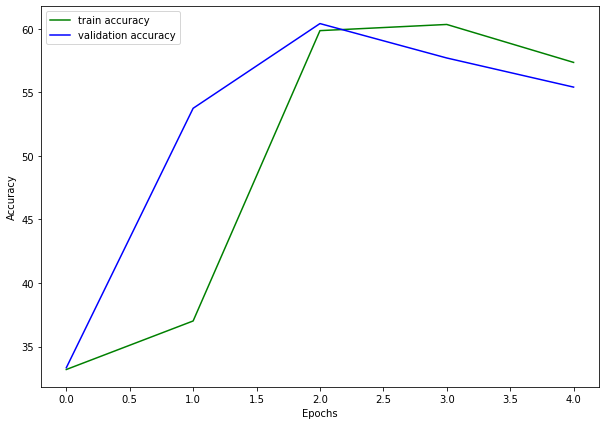

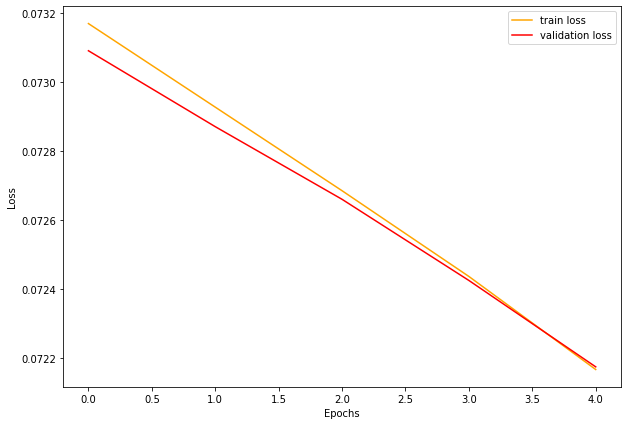

In [243]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()